# Short notebook 2: 190.529


Group members: Alice Madama 104807, Arianna Cagali 105103, Oliver Sanchez: 568003

Group Name: PCswappers

Most of the libraries used are common in machine learning, however optune, lightgbm and statsmodels.api might be missing, consider dowloading them before running the notebook.

In [15]:
import lightgbm as lgb
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import optuna
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
def preprocess_and_merge_data(observed, estimated, test, targets):
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

    #print(test_resampled['date_forecast'])

    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
     # Drop the columns not used as features
    columns_to_drop = ['is_day:idx', 'snow_density:kgm3', 'elevation:m']
    test_resampled = test_resampled.drop(columns=columns_to_drop)
    observed_resampled = observed_resampled.drop(columns=columns_to_drop)
    estimated_resampled = estimated_resampled.drop(columns=columns_to_drop)

    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
 
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values filtering for the same months
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')


    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    #print(targets.dtypes)
    # Clean up auxiliary columns
    targets_new = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast'])

    print(test_resampled.dtypes)
    print(filtered_data.dtypes)
    
    return filtered_data, test_resampled, is_day_feature, targets_new

def find_strong_correlation_pairs(data, threshold=0.95):
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Find pairs with strong correlation
    strong_correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                strong_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    # Print pairs with strong correlation
    if strong_correlation_pairs:
        print("Pairs with strong correlation:")
        for pair in strong_correlation_pairs:
            print(f"{pair[0]} and {pair[1]} have a correlation of {correlation_matrix[pair[0]][pair[1]]}")
    else:
        print("No strong correlation pairs found.")
    
    print("\n")
    return strong_correlation_pairs

def train_and_evaluate_lgbm(X_train, y_train, test_size=0.3, random_state=42, num_folds = 5):
    # Split the data into training and testing sets
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train_split, label=y_train_split)

    # Define hyperparameters
    params = {
        "objective": "regression_l1",
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "learning_rate": 0.05,
        "n_estimators": 100,
        "random_state": random_state
    }

    # Function to evaluate the model using cross-validation with MAE
    def evaluate_model(X, y, params, num_folds):
        model = lgb.LGBMRegressor(**params)
        scores = -cross_val_score(model, X, y, cv=num_folds, scoring='neg_mean_absolute_error')
        return scores

    mae_scores = evaluate_model(X_train_split, y_train_split, params, num_folds)
    print("Cross-Validation MAE scores:", mae_scores)
    print("Mean MAE:", np.mean(mae_scores))

    # Train the final model on the entire training dataset
    lgb_regressor = lgb.LGBMRegressor(**params)
    lgb_regressor.fit(X_train_split, y_train_split)

    # Make predictions on the testing dataset
    y_pred = lgb_regressor.predict(X_test_split)

    # Evaluate the model using MAE on the testing dataset
    mae = mean_absolute_error(y_test_split, y_pred)
    print("Mean Absolute Error (MAE) on the testing dataset:", mae)

    # Create an array of indices (x-values) for the data points
    x_values = range(len(y_test_split))

    # Plot the predicted values as a line with slight transparency
    plt.plot(x_values, y_pred, label='Predicted', color='blue', alpha=0.7)

    # Plot the test values as a line with slight transparency
    plt.plot(x_values, y_test_split, label='Test', color='green', alpha=0.7)

    # Add labels and a legend
    plt.xlabel('Data Point')
    plt.ylabel('Values')
    plt.legend()

    # Show the plot
    plt.show()

    return lgb_regressor



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17576 entries, 0 to 17575
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_calc                       17576 non-null  datetime64[ns]
 1   date_forecast                   17576 non-null  datetime64[ns]
 2   absolute_humidity_2m:gm3        17576 non-null  float32       
 3   air_density_2m:kgm3             17576 non-null  float32       
 4   ceiling_height_agl:m            13657 non-null  float32       
 5   clear_sky_energy_1h:J           17576 non-null  float32       
 6   clear_sky_rad:W                 17576 non-null  float32       
 7   cloud_base_agl:m                15482 non-null  float32       
 8   dew_or_rime:idx                 17576 non-null  float32       
 9   dew_point_2m:K                  17576 non-null  float32       
 10  diffuse_rad:W                   17576 non-null  float32       
 11  di

C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a futur

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a futur

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
C:\Users\Utente\AppData\Local\Temp\ipykernel_6248\577994995.py:68: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it 

absolute_humidity_2m:gm3          float32
air_density_2m:kgm3               float32
ceiling_height_agl:m              float32
clear_sky_energy_1h:J             float32
clear_sky_rad:W                   float32
cloud_base_agl:m                  float32
dew_or_rime:idx                   float32
dew_point_2m:K                    float32
diffuse_rad:W                     float32
diffuse_rad_1h:J                  float32
direct_rad:W                      float32
direct_rad_1h:J                   float32
effective_cloud_cover:p           float32
fresh_snow_12h:cm                 float32
fresh_snow_1h:cm                  float32
fresh_snow_24h:cm                 float32
fresh_snow_3h:cm                  float32
fresh_snow_6h:cm                  float32
is_in_shadow:idx                  float32
msl_pressure:hPa                  float32
precip_5min:mm                    float32
precip_type_5min:idx              float32
pressure_100m:hPa                 float32
pressure_50m:hPa                  

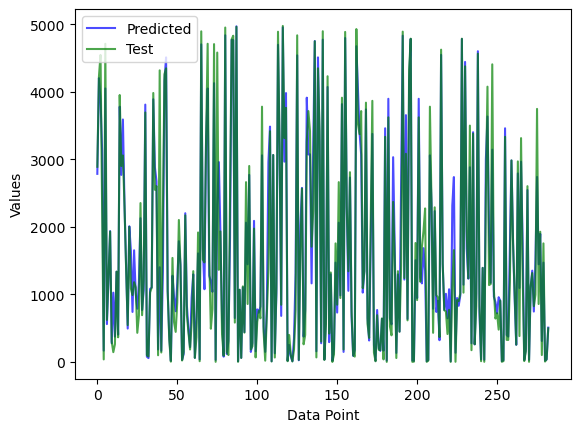

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3597
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 26
[LightGBM] [Info] Start training from score 214.763428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

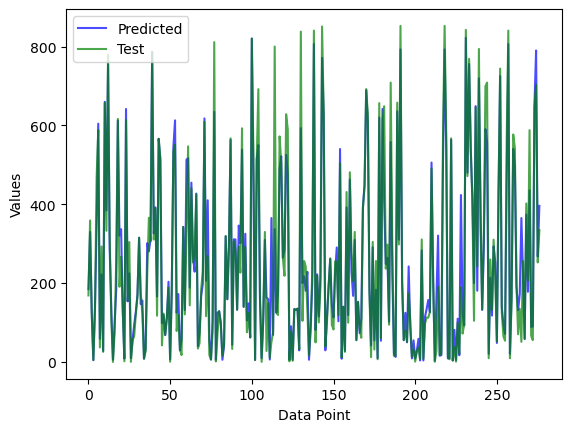

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3395
[LightGBM] [Info] Number of data points in the train set: 496, number of used features: 26
[LightGBM] [Info] Start training from score 161.209991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

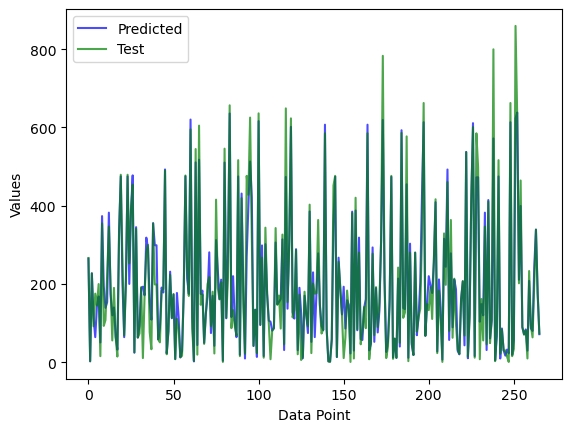

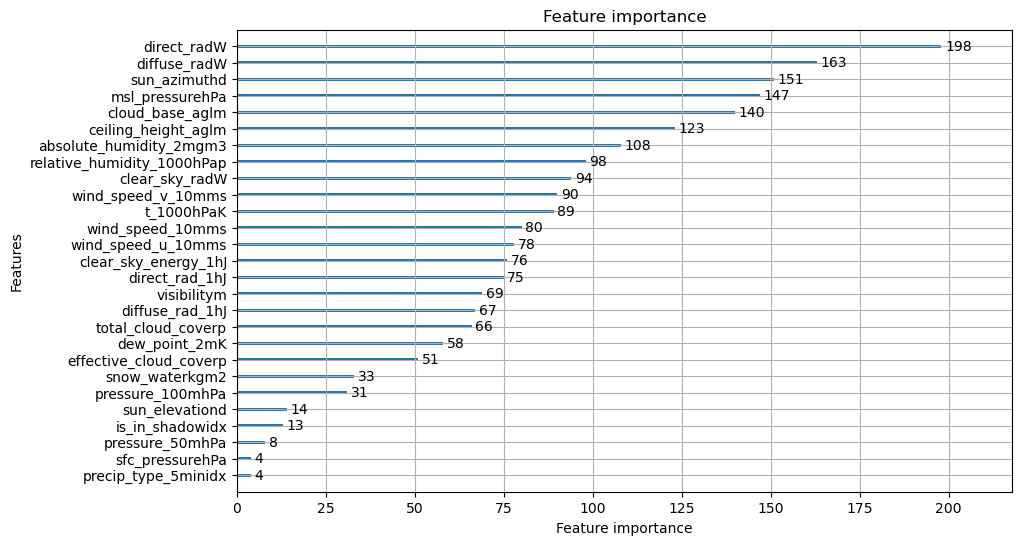

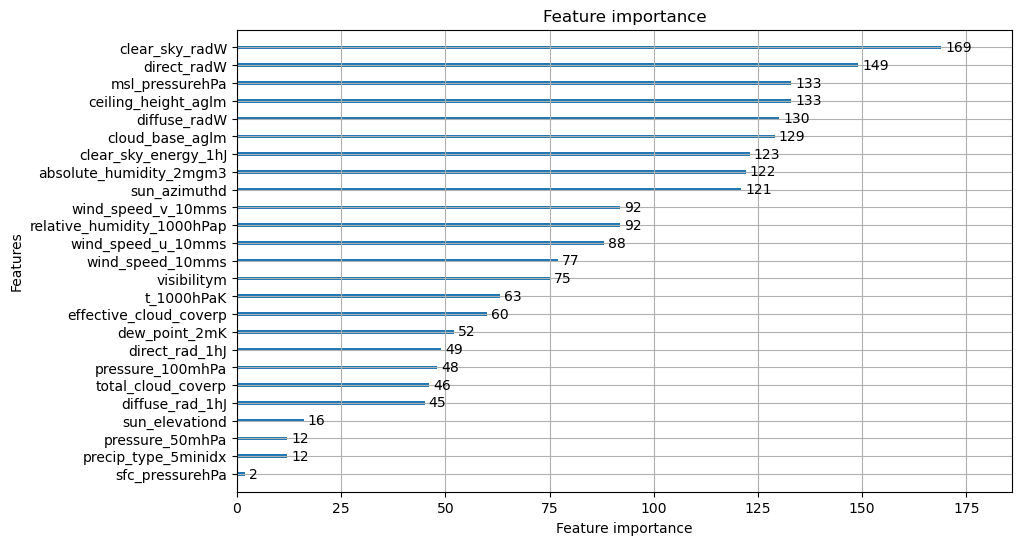

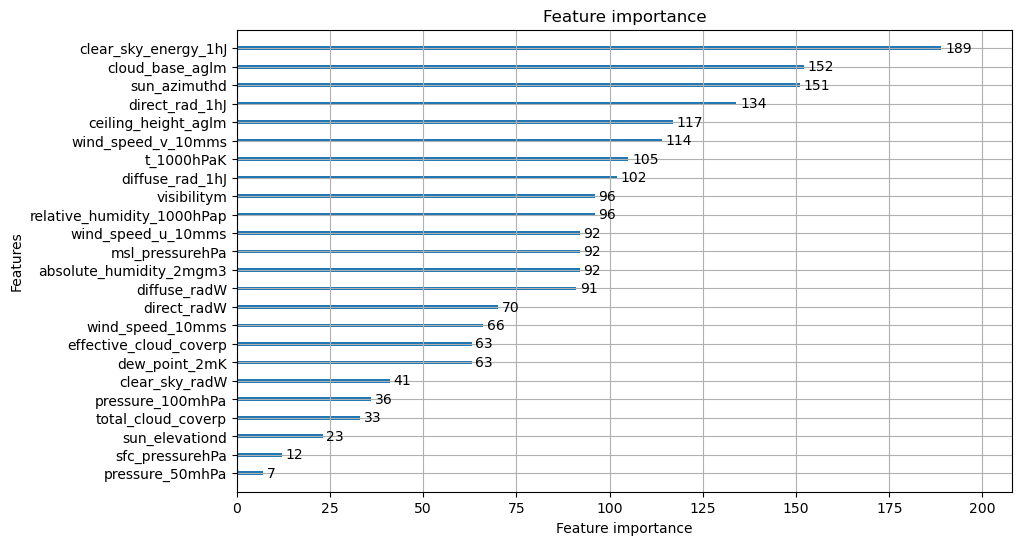

In [17]:
# Location A
train_targets_A = pd.read_parquet('data/A/train_targets.parquet')
X_train_observed_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_A = pd.read_parquet('data/A/X_train_estimated.parquet')
X_test_estimated_A = pd.read_parquet('data/A/X_test_estimated.parquet')

# Location B
train_targets_B = pd.read_parquet('data/B/train_targets.parquet')
X_train_observed_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_B = pd.read_parquet('data/B/X_train_estimated.parquet')
X_test_estimated_B = pd.read_parquet('data/B/X_test_estimated.parquet')

# Location C
train_targets_C = pd.read_parquet('data/C/train_targets.parquet')
X_train_observed_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_train_estimated_C = pd.read_parquet('data/C/X_train_estimated.parquet')
X_test_estimated_C = pd.read_parquet('data/C/X_test_estimated.parquet')

# Add a 'location' column to each dataset
X_test_estimated_A['location'] = 0
X_train_estimated_A['location'] = 0
X_train_observed_A['location'] = 0
train_targets_A['location'] = 0

X_test_estimated_B['location'] = 1
X_train_estimated_B['location'] = 1
X_train_observed_B['location'] = 1
train_targets_B['location'] = 1

X_test_estimated_C['location'] = 2
X_train_estimated_C['location'] = 2
X_train_observed_C['location'] = 2
train_targets_C['location'] = 2

# Concatenate the datasets
X_test_estimated = pd.concat([X_test_estimated_A, X_test_estimated_B, X_test_estimated_C])
X_train_estimated = pd.concat([X_train_estimated_A, X_train_estimated_B, X_train_estimated_C])
X_train_observed = pd.concat([X_train_observed_A, X_train_observed_B, X_train_observed_C])

train_targets = pd.concat([train_targets_A, train_targets_B, train_targets_C])

# Print info about training data and targets
X_train_observed_A.info()
train_targets_A.info()

X_train_observed_B.info()
train_targets_B.info()

X_train_observed_C.info()
train_targets_C.info()

# Check for missing values in pv_measurement
missing_values_A = train_targets_A['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location A: {missing_values_A}')

missing_values_B = train_targets_B['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location B: {missing_values_B}')

missing_values_C = train_targets_C['pv_measurement'].isna().sum()
print(f'Number of missing values in pv_measurement for location C: {missing_values_C}')

# Drop missing values in pv_measurement
train_targets_A.dropna(subset=['pv_measurement'], inplace=True)
train_targets_B.dropna(subset=['pv_measurement'], inplace=True)
train_targets_C.dropna(subset=['pv_measurement'], inplace=True)

merged_data_A, test_resampled_A, is_day_feature_A, targets_ny_A = preprocess_and_merge_data(X_train_observed_A, X_train_estimated_A, X_test_estimated_A, train_targets_A)
merged_data_B, test_resampled_B, is_day_feature_B, targets_ny_B = preprocess_and_merge_data(X_train_observed_B, X_train_estimated_B, X_test_estimated_B, train_targets_B)
merged_data_C, test_resampled_C, is_day_feature_C, targets_ny_C = preprocess_and_merge_data(X_train_observed_C, X_train_estimated_C, X_test_estimated_C, train_targets_C)

# Find pairs with strong correlation for each location
find_strong_correlation_pairs(merged_data_A, threshold=0.98)
find_strong_correlation_pairs(merged_data_B, threshold=0.98)
find_strong_correlation_pairs(merged_data_C, threshold=0.98)

#Ideally drop the columns with too high correlation to avoid multicolinearity
merged_data_A = merged_data_A.drop(columns=[])
merged_data_B = merged_data_B.drop(columns=[])
merged_data_C = merged_data_C.drop(columns=[])

test_A = test_resampled_A.drop(columns=[])
test_B = test_resampled_B.drop(columns=[])
test_C = test_resampled_C.drop(columns=[])

# Drop dtime columns
merged_data_A=merged_data_A = merged_data_A.select_dtypes(exclude=['datetime'])
merged_data_B=merged_data_B.select_dtypes(exclude=['datetime'])
merged_data_C=merged_data_C.select_dtypes(exclude=['datetime'])

test_resampled_A=test_resampled_A.select_dtypes(exclude=['datetime'])
test_resampled_B=test_resampled_B.select_dtypes(exclude=['datetime'])
test_resampled_C=test_resampled_C.select_dtypes(exclude=['datetime'])


#Check for constant features that can be dropped
vt = VarianceThreshold(threshold = 0.025)
vt.fit(merged_data_A)

variance_df = pd.DataFrame({'variance':vt.variances_, 'select_feature':vt.get_support()}, index=merged_data_A.columns)
merged_data_A_subset = merged_data_A.iloc[:,vt.get_support()]

print('\nColumns with select_feature=False (location A):\n')
print(variance_df[variance_df['select_feature'] == False])

vt = VarianceThreshold(threshold = 0.05)
vt.fit(merged_data_B)

variance_df = pd.DataFrame({'variance':vt.variances_, 'select_feature':vt.get_support()}, index=merged_data_A.columns)
merged_data_B_subset = merged_data_B.iloc[:,vt.get_support()]

print('\nColumns with select_feature=False (location B):\n')
print(variance_df[variance_df['select_feature'] == False])

vt = VarianceThreshold(threshold = 0.05)
vt.fit(merged_data_C)

variance_df = pd.DataFrame({'variance': vt.variances_, 'select_feature': vt.get_support()}, index=merged_data_A.columns)
merged_data_C_subset = merged_data_C.iloc[:, vt.get_support()]

print('\nColumns with select_feature=False (location C):\n')
print(variance_df[variance_df['select_feature'] == False])

# Rename columns for LightGBM compatibility
merged_data_A_subset = merged_data_A_subset.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Rename columns for LightGBM compatibility
merged_data_B_subset = merged_data_B_subset.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Rename columns for LightGBM compatibility
merged_data_C_subset = merged_data_C_subset.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

# Define the features (X) and target (y)
X_train_A_lgbm = merged_data_A_subset
y_train_A = targets_ny_A['pv_measurement']

X_train_B_lgbm = merged_data_B_subset
y_train_B = targets_ny_B['pv_measurement']

X_train_C_lgbm = merged_data_C_subset
y_train_C = targets_ny_C['pv_measurement']

# Build and train LightGBM
trained_model_A = train_and_evaluate_lgbm(X_train_A_lgbm, y_train_A, num_folds = 5)
trained_model_B = train_and_evaluate_lgbm(X_train_B_lgbm, y_train_B, num_folds = 5)
trained_model_C = train_and_evaluate_lgbm(X_train_C_lgbm, y_train_C, num_folds = 5)

# Plot feature importance
lgb.plot_importance(trained_model_A, figsize=(10, 6))
plt.show()

# Plot feature importance
lgb.plot_importance(trained_model_B, figsize=(10, 6))
plt.show()

# Plot feature importance
lgb.plot_importance(trained_model_C, figsize=(10, 6))
plt.show()

In [18]:
columns_to_keep_A = X_train_A_lgbm.columns
columns_to_keep_B = X_train_B_lgbm.columns
columns_to_keep_C = X_train_C_lgbm.columns

test_A = test_A.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
test_B = test_B.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
test_C = test_C.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

print(test_A.columns)

test_A_f_lgbm = test_A[columns_to_keep_A]
test_B_f_lgbm = test_B[columns_to_keep_B]
test_C_f_lgbm = test_C[columns_to_keep_C]

predictions_A_lgbm = trained_model_A.predict(test_A_f_lgbm)
predictions_B_lgbm = trained_model_B.predict(test_B_f_lgbm)
predictions_C_lgbm = trained_model_C.predict(test_C_f_lgbm)

# Concatenate adjusted_final_predictions for locations A, B, and C
final_predictions = np.concatenate([predictions_A_lgbm, predictions_B_lgbm, predictions_C_lgbm])

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('lgbm_predictions.csv', index=False)

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_depthcm',
       'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2', 'sun_azimuthd',
       'sun_elevationd', 'super_cooled_liquid_waterkgm2', 't_1000hPaK',
       'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'location'],
      dtype='object')
